In [34]:
!pip install opencv-python requests
!sudo apt install imagemagick -y


[notice] A new release of pip available: 22.2 -> 22.3
[notice] To update, run: pip install --upgrade pip
Reading package lists... Done
Building dependency tree       
Reading state information... Done
imagemagick is already the newest version (8:6.9.10.23+dfsg-2.1ubuntu11.4).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.


In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [3]:
# Check if GPUs are enabled for training
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2022-10-29 06:10:55.912370: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-29 06:10:55.958616: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-29 06:10:55.958933: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
data_dir = './PokemonData'

In [25]:
# prepare data
!chmod u+x mogrifyScript.sh
!./mogrifyScript.sh
!python3 skewData.py

Processing ./PokemonData/Pikachu/00000009.png ...
Processing ./PokemonData/Pikachu/00000058.png ...
Processing ./PokemonData/Pikachu/00000020.png ...
Processing ./PokemonData/Pikachu/00000036.png ...
Processing ./PokemonData/Pikachu/00000011.png ...
Processing ./PokemonData/Pikachu/00000021.png ...
Processing ./PokemonData/Pikachu/00000074.png ...
Processing ./PokemonData/Pikachu/00000043.png ...
Processing ./PokemonData/Pikachu/00000050.png ...
Processing ./PokemonData/Pikachu/00000015.png ...
Processing ./PokemonData/Pikachu/00000055.png ...
Processing ./PokemonData/Pikachu/00000069.png ...
Processing ./PokemonData/Pikachu/00000002.png ...
Processing ./PokemonData/Pikachu/00000023.png ...
Processing ./PokemonData/Pikachu/00000024.png ...
Processing ./PokemonData/Pikachu/00000066.png ...
Processing ./PokemonData/Pikachu/00000038.png ...
Processing ./PokemonData/Pikachu/00000035.png ...
Processing ./PokemonData/Pikachu/00000067.png ...
Processing ./PokemonData/Pikachu/00000031.png ...


In [26]:
# Set variables to reformat img heights and width and set batch size.
img_height,img_width=300,300
batch_size=32

In [27]:
# Create a training dataset with 80% of the data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  label_mode="int",
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 27280 files belonging to 150 classes.
Using 21824 files for training.


In [28]:
# Create a validation dataset with 20% of the data
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  label_mode="int",
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 27280 files belonging to 150 classes.
Using 5456 files for validation.


['Abra', 'Aerodactyl', 'Alakazam', 'Alolan Sandslash', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise', 'Bulbasaur', 'Butterfree', 'Caterpie', 'Chansey', 'Charizard', 'Charmander', 'Charmeleon', 'Clefable', 'Clefairy', 'Cloyster', 'Cubone', 'Dewgong', 'Diglett', 'Ditto', 'Dodrio', 'Doduo', 'Dragonair', 'Dragonite', 'Dratini', 'Drowzee', 'Dugtrio', 'Eevee', 'Ekans', 'Electabuzz', 'Electrode', 'Exeggcute', 'Exeggutor', 'Farfetchd', 'Fearow', 'Flareon', 'Gastly', 'Gengar', 'Geodude', 'Gloom', 'Golbat', 'Goldeen', 'Golduck', 'Golem', 'Graveler', 'Grimer', 'Growlithe', 'Gyarados', 'Haunter', 'Hitmonchan', 'Hitmonlee', 'Horsea', 'Hypno', 'Ivysaur', 'Jigglypuff', 'Jolteon', 'Jynx', 'Kabuto', 'Kabutops', 'Kadabra', 'Kakuna', 'Kangaskhan', 'Kingler', 'Koffing', 'Krabby', 'Lapras', 'Lickitung', 'Machamp', 'Machoke', 'Machop', 'Magikarp', 'Magmar', 'Magnemite', 'Magneton', 'Mankey', 'Marowak', 'Meowth', 'Metapod', 'Mew', 'Mewtwo', 'Moltres', 'MrMime', 'Muk', 'Nidoking', 'Ni

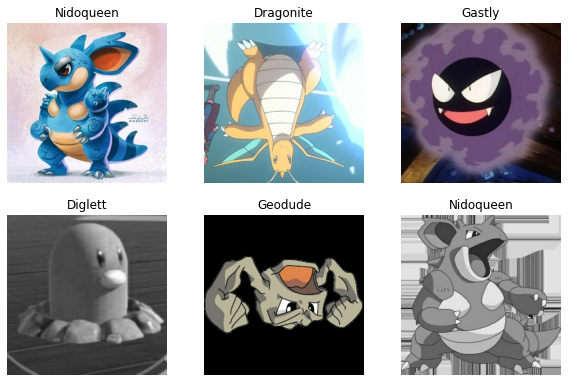

In [29]:
# View classnames and check if images are loaded properly
class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [30]:
# enable multi-gpu
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))


with strategy.scope():
    model = Sequential()
    # import pretrained model and output layer (where learning will take place)
    pretrained_model= tf.keras.applications.vgg19.VGG19(include_top=False,
                       input_shape=(300,300,3),
                       pooling='avg',classes=150,
                       weights='imagenet')
    for layer in pretrained_model.layers:
            layer.trainable=False

    model.add(pretrained_model)

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(150, activation='softmax'))
    model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 150)               76950     
                                                                 
Total params: 20,363,990
Trainable params: 339,606
Non-trainable params: 20,024,384
_________________________________________________________________


In [31]:
model.compile(optimizer=Adam(lr=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10


2022-10-29 06:57:31.550673: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 21824
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\026TensorSliceDataset:142"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
   

682/682 [==============================] - ETA: 0s - loss: 2.0100 - accuracy: 0.5588

2022-10-29 06:59:28.479675: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 5456
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\026TensorSliceDataset:149"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
    

682/682 [==============================] - 145s 208ms/step - loss: 2.0100 - accuracy: 0.5588 - val_loss: 0.8556 - val_accuracy: 0.7782
Epoch 2/10
682/682 [==============================] - ETA: 0s - loss: 0.4995 - accuracy: 0.8623

2022-10-29 07:01:44.133187: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


682/682 [==============================] - 134s 196ms/step - loss: 0.4995 - accuracy: 0.8623 - val_loss: 0.5885 - val_accuracy: 0.8363
Epoch 3/10
682/682 [==============================] - ETA: 0s - loss: 0.2616 - accuracy: 0.9270

2022-10-29 07:03:59.809243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


682/682 [==============================] - 139s 203ms/step - loss: 0.2616 - accuracy: 0.9270 - val_loss: 0.4960 - val_accuracy: 0.8633
Epoch 4/10
682/682 [==============================] - ETA: 0s - loss: 0.1769 - accuracy: 0.9485

2022-10-29 07:06:27.167340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


682/682 [==============================] - 145s 213ms/step - loss: 0.1769 - accuracy: 0.9485 - val_loss: 0.4746 - val_accuracy: 0.8680
Epoch 5/10
682/682 [==============================] - ETA: 0s - loss: 0.1540 - accuracy: 0.9538

2022-10-29 07:08:50.437490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


682/682 [==============================] - 143s 210ms/step - loss: 0.1540 - accuracy: 0.9538 - val_loss: 0.5374 - val_accuracy: 0.8600
Epoch 6/10
682/682 [==============================] - ETA: 0s - loss: 0.1522 - accuracy: 0.9534

2022-10-29 07:11:13.067022: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


682/682 [==============================] - 143s 210ms/step - loss: 0.1522 - accuracy: 0.9534 - val_loss: 0.4509 - val_accuracy: 0.8781
Epoch 7/10
682/682 [==============================] - ETA: 0s - loss: 0.1211 - accuracy: 0.9635

2022-10-29 07:13:36.194149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


682/682 [==============================] - 143s 209ms/step - loss: 0.1211 - accuracy: 0.9635 - val_loss: 0.5603 - val_accuracy: 0.8602
Epoch 8/10
682/682 [==============================] - ETA: 0s - loss: 0.1117 - accuracy: 0.9686

2022-10-29 07:15:59.122714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


682/682 [==============================] - 143s 209ms/step - loss: 0.1117 - accuracy: 0.9686 - val_loss: 0.6054 - val_accuracy: 0.8596
Epoch 9/10
682/682 [==============================] - ETA: 0s - loss: 0.1352 - accuracy: 0.9580

2022-10-29 07:18:21.949955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


682/682 [==============================] - 143s 209ms/step - loss: 0.1352 - accuracy: 0.9580 - val_loss: 0.5337 - val_accuracy: 0.8805
Epoch 10/10
682/682 [==============================] - ETA: 0s - loss: 0.1195 - accuracy: 0.9645

2022-10-29 07:20:45.089696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


682/682 [==============================] - 144s 211ms/step - loss: 0.1195 - accuracy: 0.9645 - val_loss: 0.5065 - val_accuracy: 0.8867


In [32]:
model.save(os.path.join('./results','pokemonclassifierVGG19.h5'))
tf.saved_model.save(model, './results/saved_model')

2022-10-29 07:25:18.604108: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./results/saved_model/assets


In [41]:
from keras.models import load_model
inference_model = load_model('./results/pokemonclassifierVGG19.h5')
# inference_model = model

In [39]:
# download image from the web to perform inference
pic_url = "https://www.kindpng.com/picc/m/17-176253_transparent-kabuto-png-pokemon-kabutops-mega-evolution-png.png"
with open('pic1.jpg', 'wb') as handle:
    response = requests.get(pic_url, stream=True)

    if not response.ok:
        print(response)

    for block in response.iter_content(1024):
        if not block:
            break

        handle.write(block)

In [42]:
import cv2
import pathlib
import requests
# Perform inference with training data

# inference_dir = pathlib.Path(data_dir)
# selected_pokemon = list(inference_dir.glob('Golem/*'))[0]

# Perform Inference with new data
selected_pokemon = pathlib.Path("./pic1.jpg")
PIL.Image.open(str(selected_pokemon))

image=cv2.imread(str(selected_pokemon))
image_resized= cv2.resize(image, (img_height,img_width))
image=np.expand_dims(image_resized,axis=0)
print(image.shape)

pred=inference_model.predict(image)
output_class=class_names[np.argmax(pred)]
print("The predicted class is", output_class)

(1, 300, 300, 3)
The predicted class is Seadra
